In [1]:
using Pkg, Logging
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras"));

In [2]:
Pkg.instantiate()
with_logger(NullLogger()) do
    pkg"precompile"
end

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [3]:
using MINLPTrajOpt
using MeshCat
using MeshCatMechanisms
using RigidBodyDynamics
using LinearAlgebra
using Random
using TrigonometricPolynomials
using Rotations

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [4]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = false;

In [5]:
T = Float64
world = RigidBody{T}("world")
mechanism = Mechanism(world)
joint = Joint("joint", QuaternionSpherical{T}())
Ixx = 1.
Iyy = 0.7
Izz = 1.4
inertia = SpatialInertia{T}(joint.frame_after, Diagonal([Ixx, Iyy, Izz]), zeros(3), 30.0)
body = RigidBody(inertia)
attach!(mechanism, world, body, joint);

In [6]:
@time mvis = MechanismVisualizer(mechanism, Skeleton(inertias=true));
with_logger(NullLogger()) do
    open(mvis)
end
frame = frame_after(joint)
setobject!(mvis[frame]["triad"], Triad(0.5));

 14.063609 seconds (40.35 M allocations: 1.984 GiB, 8.35% gc time)


In [7]:
using JuMP
using BARON

In [8]:
N = 10
objective = MinEffort()
T = objective isa MinEffort ? 1.0 : nothing
fixedstep = objective isa MinEffort

if fixedstep
    Δt = T / N
    Δtmin = Δt
    Δtmax = Δt
else
    Δtmin = 1e-3
    Δtmax = 0.5
end
Δθmax = 0.6#vmax * Δtmin

x0 = MechanismState(mechanism)
Random.seed!(1)
rand!(x0)
xf = MechanismState(mechanism)

solver = BaronSolver(threads=Sys.CPU_THREADS, EpsA=1e-2, MaxTime=1 * 60.0, PrTimeFreq=5.)
problem = TrajOptProblem(mechanism, x0, solver;
    xf=xf, Δtmin=Δtmin, Δtmax=Δtmax, T=T, N=N, Δθmax=Δθmax, objective=objective);

In [9]:
# for i = 1 : N
#     @constraint problem.model problem.τs[i] ⋅ problem.τs[i] <= 10
# end

In [10]:
status = solve(problem.model)

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  15.5126305861     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s) 

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /home/twan/.julia/packages/JuMP/Xvn0n/src/nlp.jl:1283


:UserLimit

In [11]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "so3", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(dirname(problem.model.internalModel.options[:SumName]), joinpath(datadir, "baronfiles"))
end

In [12]:
ts = [0; cumsum(getvalue.(problem.Δts))]
q0 = configuration(x0)
qs = [broadcast!(getvalue, similar(q, Float64), q) for q in problem.qs]; pushfirst!(qs, q0)
Δqs = [broadcast!(getvalue, similar(Δq, Float64), Δq) for Δq in problem.Δqs]
vs = [broadcast!(getvalue, similar(v, Float64), v) for v in problem.vs];
τs = [broadcast!(getvalue, similar(τ, Float64), τ) for τ in problem.τs];

In [13]:
setanimation!(mvis, ts, qs)

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #setanimation!#4(::Int64, ::Bool, ::Int64, ::Function, ::MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,QuaternionSpherical{Float64}},1}},1}},Visualizer}, ::Array{Float64,1}, ::Array{SegmentedVector{JointID,Float64,Base.OneTo{JointID},Array{Float64,1}},1}) at animate.jl:46
└ @ MeshCatMechanisms /home/twan/.julia/packages/MeshCatMechanisms/AHOtT/src/animate.jl:46


In [14]:
θs = map(qs) do q
    quat = Quat(q..., false)
    rotation_angle(quat)
end;

In [15]:
using Test
for Δq in Δqs
    Δquat = Quat(Δq..., false)
    Δθ = 2 * acos(Δquat.w)
    @test Δθ <= Δθmax + 1e-6
    @test norm([Δquat.w, Δquat.x, Δquat.y, Δquat.z]) ≈ 1 atol=1e-6
end

In [16]:
using PlottingTools
using PlottingTools.LaTeXStrings
using PlottingTools.PGFPlotsX
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

PDFLATEX::LaTeXEngine = 1

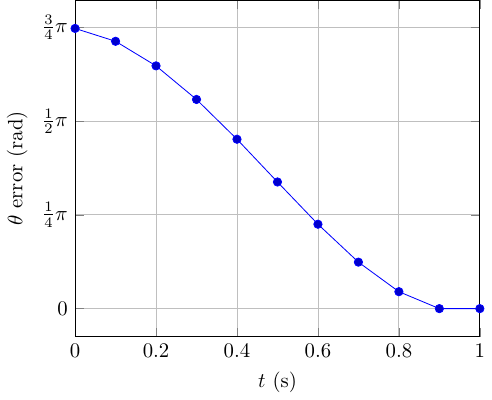

In [17]:
p = timeplot(ts, θs; ylabel=L"$\theta$ error (rad)")
piticks!(p, 1//4, θs; axis=:y)
save_data && pgfsave(joinpath(datadir, "error.pdf"), p)
p